In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
# import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib
from matplotlib.ticker import AutoMinorLocator


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat

def get_ripple_fr(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

basepath = r'Z:\Data\Kenji\km01.012_020'

cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

restrict_idx = (
                    (cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False) 
                    )

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

# behavioral epochs
epoch_df = loading.load_epoch(basepath)
# some epochs will have repeating back to back sessions that are actually the same session
epoch_df = functions.compress_repeated_epochs(epoch_df)

behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                epoch_df.stopTime]).T])

# unit_mat = get_ripple_fr(st_unit[ripple_epochs],ripple_epochs)
unit_mat = get_participation(st_unit[ripple_epochs],ripple_epochs)

unit_mat = nel.AnalogSignalArray(data=unit_mat,timestamps=ripple_epochs.starts)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:236: UserWarning: fs was not specified, so we try to estimate it from the data...
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:238: UserWarning: fs was estimated to be 0.7718431614696357 Hz
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support

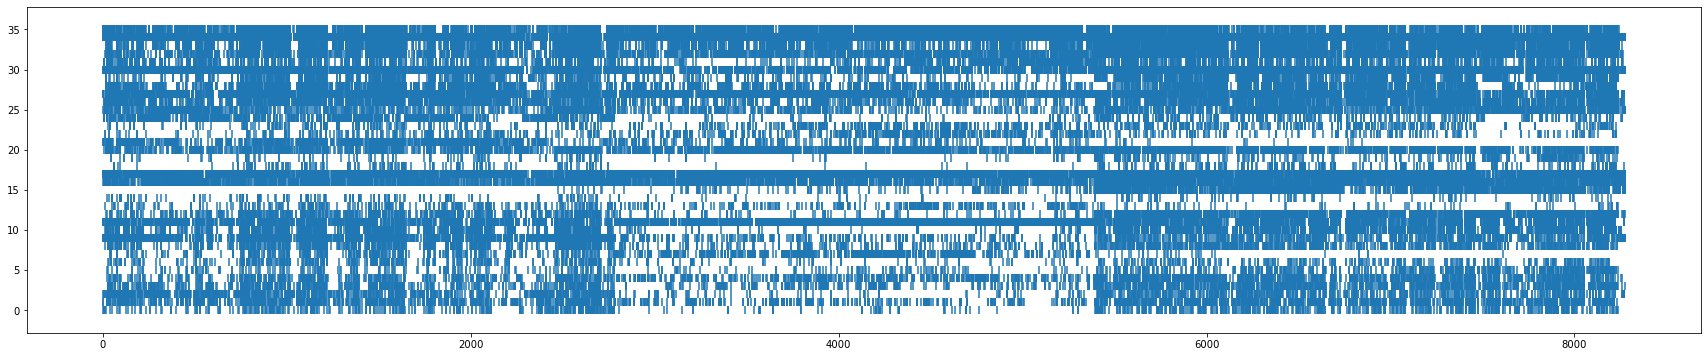

In [3]:
plt.figure(figsize=(30,6))
plt.eventplot(st_unit.data)
plt.show()

In [52]:
# from statsmodels.nonparametric.kernel_regression import KernelReg
# kr = KernelReg(unit_mat.data[3],unit_mat.abscissa_vals,'o')
# y_pred, y_std = kr.fit(x)

# index = np.arange(unit_mat.abscissa_vals.min(), unit_mat.abscissa_vals.max(),1/1250)

# np.interp(unit_mat.abscissa_vals,index,) 

# unit_mat.abscissa_vals

# np.diff(unit_mat.abscissa_vals).min()
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(unit_mat.abscissa_vals.reshape(-1, 1), unit_mat.data[3])


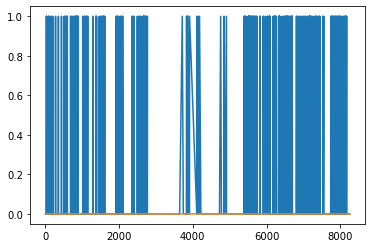

In [ ]:
# y_pred, y_std = kr.fit(unit_mat.abscissa_vals)
y_pred,y_std = gpr.predict(unit_mat.abscissa_vals.reshape(-1, 1), return_std=True)
plt.plot(unit_mat.abscissa_vals, unit_mat.data[3])

plt.plot(unit_mat.abscissa_vals, y_pred)


In [46]:
y_pred

(array([0.05808512, 0.05813838, 0.05814234, ..., 0.12081051, 0.12089443,
        0.12117481]),
 array([0.28708257, 0.28708209, 0.28708206, ..., 0.28707343, 0.287074  ,
        0.2870766 ]))

In [20]:
# startDate = '2015-05-15'
# endDate = '2015-12-5'
# index = pd.date_range(startDate, endDate)
# index
# index=pd.date_range(unit_mat.abscissa_vals.min(), unit_mat.abscissa_vals.max())
index = pd.Timestamp(unit_mat.abscissa_vals[0], unit='s')
test_df = pd.DataFrame(unit_mat.data[0],index=index,columns=['values'])
index_sec = pd.date_range(unit_mat.abscissa_vals.min(), unit_mat.abscissa_vals.max(), freq='1S')
index_sec = np.arange(unit_mat.abscissa_vals.min(), unit_mat.abscissa_vals.max(),1/1250)

df_smooth = test_df.reindex(index=index_sec).interpolate('cubic')


TypeError: Index(...) must be called with a collection of some kind, Timestamp('1970-01-01 00:00:01.497600') was passed

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


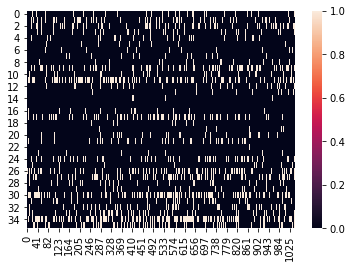

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


<AxesSubplot:>

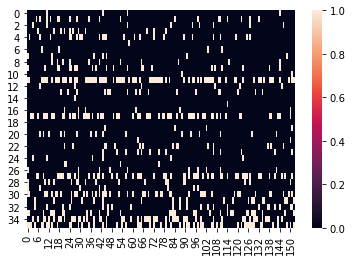

In [4]:
sns.heatmap(unit_mat[behavioral_epochs[0]].data)
plt.show()
sns.heatmap(unit_mat[behavioral_epochs[1]].data)


In [5]:
unit_mat_sm = unit_mat.smooth(sigma=30)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


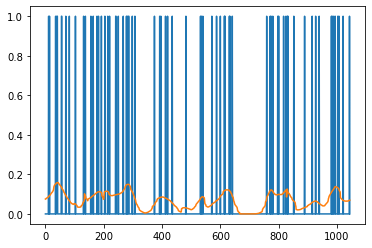

In [6]:
plt.plot(unit_mat[behavioral_epochs[0]].data[3])
plt.plot(unit_mat_sm[behavioral_epochs[0]].data[3])

plt.show()


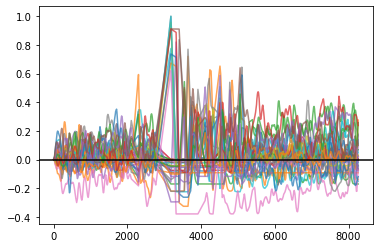

In [7]:
first_val = [um[0] for um in unit_mat_sm.data]

plt.plot(unit_mat_sm.abscissa_vals,unit_mat_sm.data.T - first_val,alpha=.7)
# plt.xlim(0,1000)
plt.axhline(0,color='k')
plt.show()

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


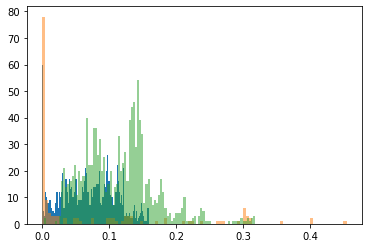

In [8]:
plt.hist(unit_mat_sm[behavioral_epochs[0]].data[3],100)
plt.hist(unit_mat_sm[behavioral_epochs[1]].data[3],100,alpha=.5)
plt.hist(unit_mat_sm[behavioral_epochs[2]].data[3],100,alpha=.5)
# plt.xscale('log')
plt.show()
